# Import

In [1]:
from absl import flags
import sys
FLAGS = flags.FLAGS
FLAGS(sys.argv[:1])

import time # 프레임 당 시간 계산하기위해서 필요함
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from yolov3_tf2.models import YoloV3
from yolov3_tf2.dataset import transform_images
from yolov3_tf2.utils import convert_boxes

from bytetrack import data_util
from bytetrack import preprocessing # NMS
from bytetrack import matching
from bytetrack.detection import Detection
from bytetrack.tracker import BYTETracker
from bytetrack.tracking_utils import match_detections_with_tracks

from typing import List

# Detection Model Load

In [2]:
class_names = [c.strip() for c in open('./data/labels/coco.names').readlines()] # [car, person, ... ]
yolo = YoloV3(classes=len(class_names))
yolo.load_weights('./weights/yolov3.tf')

# frame 단위로 video capture 

In [4]:
'''동영상 파일 사용시
# frame 단위로 video capture
vid = cv2.VideoCapture('./data/video/test.mp4')

codec = cv2.VideoWriter_fourcc(*'XVID')
vid_fps = int(vid.get(cv2.CAP_PROP_FPS)) # CAP_PROP_FPS는 float을 반환해서 int로 바꿔줌 
vid_width, vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('./data/video/results.avi', codec, vid_fps, (vid_width, vid_height))
'''

"동영상 파일 사용시\n# frame 단위로 video capture\nvid = cv2.VideoCapture('./data/video/test.mp4')\n\ncodec = cv2.VideoWriter_fourcc(*'XVID')\nvid_fps = int(vid.get(cv2.CAP_PROP_FPS)) # CAP_PROP_FPS는 float을 반환해서 int로 바꿔줌 \nvid_width, vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))\nout = cv2.VideoWriter('./data/video/results.avi', codec, vid_fps, (vid_width, vid_height))\n"

## Vis-Drone 데이터셋 받아오기

In [3]:
import glob

test_dir_path = 'C:/Users/Son/Documents/aiffel/SIA-MOT/VisDrone2019-MOT-test/VisDrone2019-MOT-test/sequences/'
test_dir_names = glob.glob(test_dir_path+'*')

images_filepaths=[]
for d in test_dir_names:
    paths = sorted(glob.glob(d+"/*"))
    images_filepaths += paths
len(images_filepaths)

6635

In [41]:
import pandas as pd
a = pd.read_csv("C:/Users/Son/Documents/aiffel/SIA-MOT/VisDrone2019-MOT-test/test_detection_frame.csv")
b = a.columns.tolist()
b

['video_name',
 'frame_index',
 'img_path',
 'target_ids',
 'x_min',
 'x_max',
 'y_min',
 'y_max',
 'x_cen',
 'y_cen',
 'b_width',
 'b_height',
 'height',
 'width',
 'classes',
 'obj']

In [42]:
pred_detection = pd.read_csv('C:/Users/Son/Documents/aiffel/SIA-MOT/VisDrone2019-MOT-test/pred_boxes.txt',
                             sep = ",",
                            names = ['image_index', 'class', 'conf', 'xcen','ycen', 'width','height'])
pred_detection

,image_index,class,conf,xcen,ycen,width,height
0,0,0.0,0.881958,0.185493,0.690349,0.111965,0.060094
1,0,0.0,0.865220,0.300321,0.382030,0.078365,0.039684
2,0,0.0,0.828145,0.973311,0.455008,0.051629,0.050034
3,0,0.0,0.801469,0.285692,0.411571,0.084432,0.047244
4,0,0.0,0.800277,0.598383,0.395733,0.080952,0.059354
...,...,...,...,...,...,...,...
304428,6633,0.0,0.505700,0.046380,0.431168,0.030037,0.016029
304429,6633,0.0,0.284306,0.414750,0.396237,0.018441,0.014409
304430,6633,0.0,0.165571,0.336628,0.400010,0.019682,0.013407
304431,6633,0.0,0.142593,0.353096,0.398874,0.018987,0.013111


In [43]:
pred_detection_0 = pred_detection[pred_detection['image_index']<219]
pred_detection_0.iloc[:,1] = 2
pred_detection_0

C:\Users\Son\AppData\Local\Temp\ipykernel_5104\2031871295.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_detection_0.iloc[:,1] = 2
C:\Users\Son\AppData\Local\Temp\ipykernel_5104\2031871295.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pred_detection_0.iloc[:,1] = 2


,image_index,class,conf,xcen,ycen,width,height
0,0,2,0.881958,0.185493,0.690349,0.111965,0.060094
1,0,2,0.865220,0.300321,0.382030,0.078365,0.039684
2,0,2,0.828145,0.973311,0.455008,0.051629,0.050034
3,0,2,0.801469,0.285692,0.411571,0.084432,0.047244
4,0,2,0.800277,0.598383,0.395733,0.080952,0.059354
...,...,...,...,...,...,...,...
6609,218,2,0.108942,0.697528,0.590375,0.013059,0.021172
6610,218,2,0.104747,0.408021,0.530940,0.016954,0.037827
6611,218,2,0.087751,0.389708,0.274807,0.025970,0.038401
6612,218,2,0.064337,0.553111,0.679891,0.015969,0.042284


In [9]:
yolo_pred = pred_detection_0[pred_detection_0['image_index']==0]

In [10]:
boxs = yolo_pred.iloc[:,3:].to_numpy()
scores = yolo_pred['conf'].to_numpy()
classes = yolo_pred['class'].to_numpy()
nums=len(yolo_pred['image_index']==0)

In [11]:
scores[np.newaxis,:]

array([[0.88195783, 0.86521989, 0.82814479, 0.80146927, 0.80027729,
        0.79316008, 0.77400368, 0.74861079, 0.66380382, 0.58474553,
        0.57139593, 0.29249275, 0.24670424, 0.11772887, 0.11270597]])

In [4]:
import glob

test_paths = sorted(glob.glob(test_dir_names[3]+'/*'))
len(test_paths)

780

In [5]:
a = cv2.imread(test_paths[3])
a_height, a_width = a.shape[0], a.shape[1]
codec = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('./data/video/results_3.avi', codec, 30, (a_width, a_height))

# Tracking Start

In [6]:
# tracker class 선언
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

args = BYTETrackerArgs()
tracker = BYTETracker(args)

model_filename = 'model_data/mars-small128.pb'

In [47]:

''' 동영상 파일 사용시
while True:
    
    _, img = vid.read() # img : ndarray (height, width,channel) 한장씩 받아옴
    if img is None:
        print('Completed')
        break
    
    img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_in = tf.expand_dims(img_in, 0) # detector에 넣어주기 위해서 (1,height, width, channel)로 만들어줌 >> tf.Tensor로 바뀜
    img_in = transform_images(img_in, 416)  # 1. image resize >> 416으로, 2. 픽셀값 255로 나눠줌. 
    
    t1 = time.time()
    
    boxes, scores, classes, nums = yolo.predict(img_in)
    
    classes = classes[0]

    # box정보가 [0,0,0,0]이 아닌 것만 받음
    # box shape : x_min, y_min, w, h로 바뀜 & image 크기로 reshape
    converted_boxes = convert_boxes(img, boxes[0])

    #####################################################
    # 여기부터 bytetrack폴더에 있는 파일 사용

    # 박스정보 : left, top, width, height
    detections = [Detection(bbox, score, classes) for bbox, score, classes in
                  zip(converted_boxes, scores[0], classes)]

    boxs = np.array([d.to_xyxy() for d in detections]) # to_xyxy : left, top, width, height에서 x_min, y_min, x_max, y_max로 바꿔줌
    scores = np.array([d.confidence for d in detections])
    classes = np.array([d.classes for d in detections])

    tracks = tracker.update(
            output_results= np.hstack((boxs, scores[:, np.newaxis])),
            img_info=img_in.shape,
            img_size=img_in.shape
        )
    
    # match_detections_with_tracks를 해줄 필요는 없는 거 같은데 왜 쓴 건지는 알아보는 중
    # 현재 detection box와 현재추적중인 track사이의 IoU matching
    # 더 정확히 matching시켜주기 위함이 아닐까 함.
    track_id = match_detections_with_tracks(boxs=boxs, tracks=tracks)
    for i,detection in enumerate(detections):
        detection.add_track_id(track_id[i])
    
    mask = np.array([detection.track_id is not None for detection in detections], dtype=bool)
    classes = classes[mask]
    detections = list(np.array(detections)[mask])
    
    ############################################
    # tracking 확인/ 시각화 과정
    
    cmap = plt.get_cmap('tab20b') # 숫자를 색상에 매핑
    colors = [cmap(i)[:3] for i in np.linspace(0,1,20)] # 20개 색상 생성

    current_count = int(0)
    
    for i, detection in enumerate(detections):
        if detection is None:
            continue
        bbox = detection.to_xyxy() # cv2 출력에 사용됨 min_x, min_y, max_x, max_y
        class_name = class_names[int(detection.classes)]
        color = colors[int(detection.track_id) % len(colors)]
        color = [i*255 for i in color]

        cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]),int(bbox[3])), color, 2) # lt, rb
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1]-30)), (int(bbox[0])+(len(class_name)
                        +len(str(detection.track_id)))*17,int(bbox[1])), color, -1) # id box
        cv2.putText(img, class_name+"-"+str(detection.track_id), (int(bbox[0]), int(bbox[1]-10)), 0, 0.75,
                        (255,255,255), 2)
    
    fps  = 1./(time.time()-t1)
    cv2.putText(img, "FPS: {:.2f}".format(fps), (0,30), 0, 1, (0,0,255), 2)
    cv2.namedWindow("output", cv2.WINDOW_NORMAL)
    cv2.resizeWindow('output', 1024, 768)
    cv2.imshow('output', img)
    out.write(img)

    if cv2.waitKey(1) == ord('q'): # 휴식
        break
vid.release()
out.release()
cv2.destroyAllWindows()
'''

' 동영상 파일 사용시\nwhile True:\n    \n    _, img = vid.read() # img : ndarray (height, width,channel) 한장씩 받아옴\n    if img is None:\n        print(\'Completed\')\n        break\n    \n    img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n    img_in = tf.expand_dims(img_in, 0) # detector에 넣어주기 위해서 (1,height, width, channel)로 만들어줌 >> tf.Tensor로 바뀜\n    img_in = transform_images(img_in, 416)  # 1. image resize >> 416으로, 2. 픽셀값 255로 나눠줌. \n    \n    t1 = time.time()\n    \n    boxes, scores, classes, nums = yolo.predict(img_in)\n    \n    classes = classes[0]\n\n    # box정보가 [0,0,0,0]이 아닌 것만 받음\n    # box shape : x_min, y_min, w, h로 바뀜 & image 크기로 reshape\n    converted_boxes = convert_boxes(img, boxes[0])\n\n    #####################################################\n    # 여기부터 bytetrack폴더에 있는 파일 사용\n\n    # 박스정보 : left, top, width, height\n    detections = [Detection(bbox, score, classes) for bbox, score, classes in\n                  zip(converted_boxes, scores[0], classes)]\n\n    boxs = np.arra

In [7]:
detections_dict = {}
for frame_id ,img in enumerate(test_paths):
    if img is None:
        print('Completed')
        break
    
    img = cv2.imread(img)
    img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_in = tf.expand_dims(img_in, 0) # detector에 넣어주기 위해서 (1,height, width, channel)로 만들어줌 >> tf.Tensor로 바뀜
    img_in = transform_images(img_in, 416)  # 1. image resize >> 416으로, 2. 픽셀값 255로 나눠줌.
    
   # t1 = time.time()
    
   
    boxes, scores, classes, nums = yolo.predict(img_in)
    
    classes = classes[0]
    
    # box정보가 [0,0,0,0]이 아닌 것만 받음
    # box shape : x_min, y_min, w, h로 바뀜 & image 크기로 reshape
    converted_boxes = convert_boxes(img, boxes[0])
    
    
    #####################################################
    # 여기부터 bytetrack폴더에 있는 파일 사용
    
    '''
    # with txt our data
    yolo_pred = pred_detection_0[pred_detection_0['image_index']==frame_id]
    
    boxs = yolo_pred.iloc[:,3:].to_numpy()
    scores = yolo_pred['conf'].to_numpy()[np.newaxis,:]
    classes = yolo_pred['class'].to_numpy()
    nums=len(yolo_pred['image_index']==0)
    
    converted_boxes = data_util.boxes_xycen_to_xywh(img, boxs)
    '''
    
    
    # 박스정보 : left, top, width, height
    detections = [Detection(bbox, score, classes) for bbox, score, classes in
                  zip(converted_boxes, scores[0], classes)]

    boxs = np.array([d.to_xyxy() for d in detections]) # to_xyxy : left, top, width, height에서 x_min, y_min, x_max, y_max로 바꿔줌
    scores = np.array([d.confidence for d in detections])
    classes = np.array([d.classes for d in detections])
    
    # tracks 호출 시 : track_id, start_frame, end_frame
    tracks = tracker.update(
            output_results= np.hstack((boxs, scores[:, np.newaxis])),
            img_info=img_in.shape,
            img_size=img_in.shape
        )
    '''
    if tracks == []:
        print(frame_id)
        break
    '''  
    
    # 현재 detection box와 현재추적중인 track사이의 IoU matching
    # detections에 track_id 넣어주기 위해 matching 시키는 것으로 추정
    track_id = match_detections_with_tracks(boxs=boxs, tracks=tracks)
    for i,detection in enumerate(detections):
        if tracks == []:
            break
        else:
            detection.add_track_id(track_id[i])
    
    mask = np.array([detection.track_id is not None for detection in detections], dtype=bool)
    classes = classes[mask]
    detections = list(np.array(detections)[mask])
    
    detections_dict[frame_id+1]= detections
    
    ############################################
    # tracking 확인/ 시각화 과정
    
    cmap = plt.get_cmap('tab20b') # 숫자를 색상에 매핑
    colors = [cmap(i)[:3] for i in np.linspace(0,1,20)] # 20개 색상 생성

    current_count = int(0)
    
    for i, detection in enumerate(detections):
        if detection is None:
            continue
        bbox = detection.to_xyxy() # cv2 출력에 사용됨 min_x, min_y, max_x, max_y
        class_name = class_names[int(detection.classes)]
        color = colors[int(detection.track_id) % len(colors)]
        color = [i*255 for i in color]

        cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]),int(bbox[3])), color, 2) # lt, rb
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1]-30)), (int(bbox[0])+(len(class_name)
                        +len(str(detection.track_id)))*17,int(bbox[1])), color, -1) # id box
        cv2.putText(img, class_name+"-"+str(detection.track_id), (int(bbox[0]), int(bbox[1]-10)), 0, 0.75,
                        (255,255,255), 2)
    
    #fps  = 1./(time.time()-t1)
    #cv2.putText(img, "FPS: {:.2f}".format(fps), (0,30), 0, 1, (0,0,255), 2)
    cv2.namedWindow("output", cv2.WINDOW_NORMAL)
    cv2.resizeWindow('output', 1024, 768)
    cv2.imshow('output', img)
    out.write(img)

    if cv2.waitKey(1) == ord('q'): # 휴식
        break
#vid.release()
out.release()
cv2.destroyAllWindows()

1/1 [==============================] - 1s 631ms/step


1/1 [==============================] - 1s 571ms/step


1/1 [==============================] - 1s 521ms/step


1/1 [==============================] - 1s 508ms/step


1/1 [==============================] - 1s 508ms/step


1/1 [==============================] - 1s 533ms/step


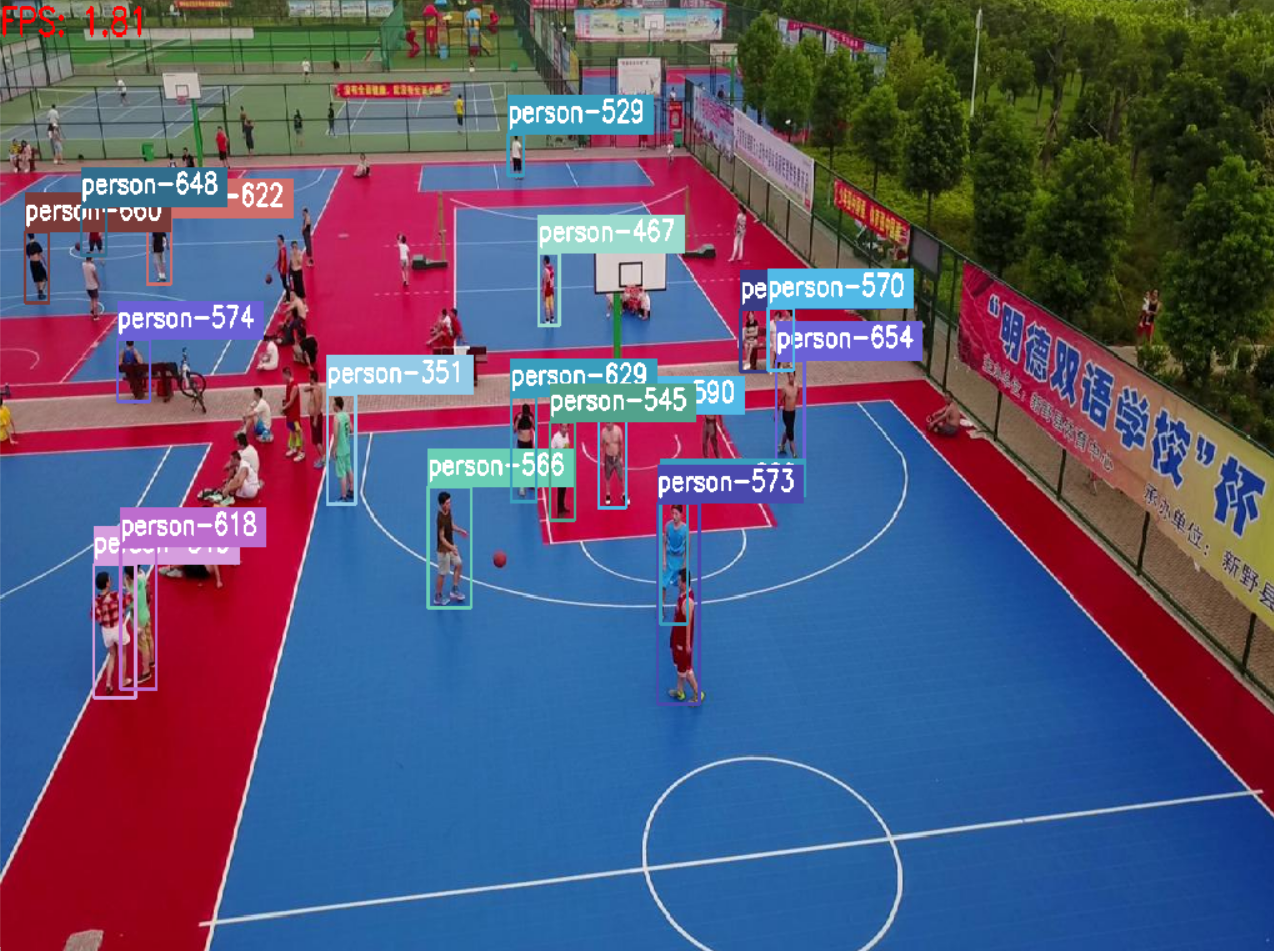

# Metric

num_tracker_dets: 추적기에서 감지한 객체의 수\
num_gt_dets: 실제 객체의 수\
gt_ids: 각 타임스텝에서의 실제 객체의 식별자(ID) 배열\
tracker_ids: 각 타임스텝에서 추적기가 예측한 객체의 식별자(ID) 배열\
similarity_scores: 타임스텝별 유사도 점수 행렬; ground thruth와 pred한 box의 유사도

### ground Truth 정보

In [8]:
from metric.io import read_results, unzip_objs

import os
import numpy as np
import copy
import motmetrics as mm
mm.lap.default_solver = 'lap'


data_root = "C:/Users/Son/Documents/aiffel/SIA-MOT/VisDrone2019-MOT-test/VisDrone2019-MOT-test/annotations/"
seq_name = 'uav0000077_00720_v'
data_type = 'mot'

gt_filename = os.path.join(data_root, seq_name + '.txt')

# {frame_num : (tlwh, target_id, score)}
gt_frame_dict = read_results(gt_filename, data_type, is_gt=True)
gt_ignore_frame_dict = read_results(gt_filename, data_type, is_ignore=True)

### 예측한 정보 추합 및 평가

In [9]:
from cython_bbox import bbox_overlaps as bbox_ious

def ious(atlwhs, btlwhs):
    """
    Compute cost based on IoU
    :type atlbrs: list[tlbr] | np.ndarray
    :type atlbrs: list[tlbr] | np.ndarray

    :rtype ious np.ndarray
    """
    atlbrs = np.concatenate([atlwhs[:,:2], atlwhs[:,2:] + atlwhs[:,:2]], axis=1)
    btlbrs = np.concatenate([btlwhs[:,:2], btlwhs[:,2:] + btlwhs[:,:2]], axis=1)
    
    ious = np.zeros([atlbrs.shape[0], btlbrs.shape[0]], dtype=np.float)
    if ious.size == 0:
        return ious
    
    trk_tlwhs_list = [i for i in trk_tlwhs]
    gt_tlwhs_list = [i for i in gt_tlwhs]
    
    ious = bbox_ious(
        np.ascontiguousarray(atlbrs, dtype=np.float),
        np.ascontiguousarray(btlbrs, dtype=np.float)
    )

    return ious

In [10]:
from bytetrack.matching import ious

accs=[]
names=[]
similarity_scores=[]
num_tracker_dets=set()
num_gt_dets=set()
gtrue_ids=[]
tracker_ids=[]
for i in range(1, len(gt_frame_dict)+1):

    # results
    trk_objs = detections_dict.get(i,[])
    trk_tlwhs = []
    trk_ids = []
    for a in trk_objs:
        trk_tlwhs.append(a.tlwh)
        trk_ids.append(a.track_id)
    trk_tlwhs = np.asarray(trk_tlwhs)
    trk_ids = np.asarray(trk_ids)
    
    # gts
    gt_objs = gt_frame_dict.get(i, [])
    gt_tlwhs, gt_ids = unzip_objs(gt_objs)[:2]

    # ignore boxes
    ignore_objs = gt_ignore_frame_dict.get(i, [])
    ignore_tlwhs = unzip_objs(ignore_objs)[0]

    # remove ignored results
    keep = np.ones(len(trk_tlwhs), dtype=bool)
    iou_distance = mm.distances.iou_matrix(ignore_tlwhs, trk_tlwhs, max_iou=0.5)
    if len(iou_distance) > 0:
        match_is, match_js = mm.lap.linear_sum_assignment(iou_distance)
        match_is, match_js = map(lambda a: np.asarray(a, dtype=int), [match_is, match_js])
        match_ious = iou_distance[match_is, match_js]

        match_js = np.asarray(match_js, dtype=int)
        match_js = match_js[np.logical_not(np.isnan(match_ious))]
        keep[match_js] = False
        trk_tlwhs = trk_tlwhs[keep]
        trk_ids = trk_ids[keep]
    
    ious_ = ious(gt_tlwhs, trk_tlwhs)
    iou_distance = mm.distances.iou_matrix(gt_tlwhs, trk_tlwhs, max_iou=0.5)
    
    acc = mm.MOTAccumulator(auto_id=True)
    acc.update(gt_ids, trk_ids, iou_distance)
    rtn_events=False

    if rtn_events and iou_distance.size > 0 and hasattr(acc, 'last_mot_events'):
        events = acc.last_mot_events  # only supported by https://github.com/longcw/py-motmetrics
    else:
        events = None
    accs.append(acc)
    names.append(i)
    
    # save
    similarity_scores.append(ious_)
    num_tracker_dets = num_tracker_dets | set(trk_ids)
    num_gt_dets = num_gt_dets | set(gt_ids)
    gtrue_ids.append(np.array(gt_ids))
    tracker_ids.append(trk_ids)

# array로 바꾸기
similarity_scores = np.asarray(similarity_scores)
num_tracker_dets=len(num_tracker_dets)
num_gt_dets= len(num_gt_dets)
gtrue_ids=np.asarray(gtrue_ids)
tracker_ids=np.asarray(tracker_ids)

C:\Users\Son\AppData\Local\Temp\ipykernel_8132\3838687622.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  similarity_scores = np.asarray(similarity_scores)
C:\Users\Son\AppData\Local\Temp\ipykernel_8132\3838687622.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gtrue_ids=np.asarray(gtrue_ids)
C:\Users\Son\AppData\Local\Temp\ipykernel_8132\3838687622.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

In [11]:
np.save("C:/Users/Son/Documents/aiffel/SIA-MOT/workplace/yolov3_bytetrack/metric_input/similarity_scores",similarity_scores)
np.save("C:/Users/Son/Documents/aiffel/SIA-MOT/workplace/yolov3_bytetrack/metric_input/num_tracker_dets",num_tracker_dets)
np.save("C:/Users/Son/Documents/aiffel/SIA-MOT/workplace/yolov3_bytetrack/metric_input/num_gt_dets",num_gt_dets)
np.save("C:/Users/Son/Documents/aiffel/SIA-MOT/workplace/yolov3_bytetrack/metric_input/gtrue_ids",gtrue_ids)
np.save("C:/Users/Son/Documents/aiffel/SIA-MOT/workplace/yolov3_bytetrack/metric_input/traker_ids",tracker_ids)

In [5]:
similarity_scores = np.load("C:/Users/Son/Documents/aiffel/SIA-MOT/workplace/yolov3_bytetrack/metric_input/similarity_scores.npy",allow_pickle=True
)
num_tracker_dets=np.load("C:/Users/Son/Documents/aiffel/SIA-MOT/workplace/yolov3_bytetrack/metric_input/num_tracker_dets.npy",allow_pickle=True)
num_gt_dets=np.load("C:/Users/Son/Documents/aiffel/SIA-MOT/workplace/yolov3_bytetrack/metric_input/num_gt_dets.npy",allow_pickle=True)
gtrue_ids=np.load("C:/Users/Son/Documents/aiffel/SIA-MOT/workplace/yolov3_bytetrack/metric_input/gtrue_ids.npy",allow_pickle=True)
tracker_ids=np.load("C:/Users/Son/Documents/aiffel/SIA-MOT/workplace/yolov3_bytetrack/metric_input/traker_ids.npy",allow_pickle=True)

In [12]:
def get_summary(accs, names, metrics=('mota', 'num_switches', 'idp', 'idr', 'idf1', 'precision', 'recall')):
    names = copy.deepcopy(names)
    if metrics is None:
        metrics = mm.metrics.motchallenge_metrics
    metrics = copy.deepcopy(metrics)

    mh = mm.metrics.create()
    summary = mh.compute_many(
            accs,
            metrics=metrics,
            names=names,
            generate_overall=True
        )

    return summary

In [13]:
s = get_summary(accs, names)
s

,mota,num_switches,idp,idr,idf1,precision,recall
1,0.538462,0,0.850000,0.653846,0.739130,0.850000,0.653846
2,0.653846,0,0.947368,0.692308,0.800000,0.947368,0.692308
3,0.538462,0,0.888889,0.615385,0.727273,0.888889,0.615385
4,0.615385,0,0.944444,0.653846,0.772727,0.944444,0.653846
5,0.615385,0,0.944444,0.653846,0.772727,0.944444,0.653846
...,...,...,...,...,...,...,...
777,0.750000,0,0.800000,1.000000,0.888889,0.800000,1.000000
778,0.500000,0,0.750000,0.750000,0.750000,0.750000,0.750000
779,0.500000,0,0.750000,0.750000,0.750000,0.750000,0.750000
780,0.750000,0,1.000000,0.750000,0.857143,1.000000,0.750000


In [23]:
s['mota'].mean()

0.35365385212875106

## Our Metric

In [20]:
from metric.MOTA import CLEAR

# 실제 적용 예시코드
# 데이터셋에서 필요한 정보를 추출하여 data 배열을 생성
data = {
    'num_tracker_dets': num_tracker_dets,
    'num_gt_dets': num_gt_dets,
    'gt_ids': gtrue_ids,
    'tracker_ids': tracker_ids,
    'similarity_scores': similarity_scores,
    'num_timesteps' : len(test_paths)
}

# CLEAR 객체 생성
clear = CLEAR()

# eval_sequence 메서드를 사용하여 MOTA 계산
mota = clear.eval_sequence(data)['MOTA']


CLEAR Config:
THRESHOLD            : 0.5                           
PRINT_CONFIG         : True                          


In [21]:
mota

-0.5350239035543546